# Feature selection 2

## Imports

In [1]:
import os
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

## Technicals variables

In [2]:
wd = os.path.dirname(os.getcwd())
train_csv = os.path.sep.join([wd, "asset", "data", "application", "application_train.csv"])
test_csv  = os.path.sep.join([wd, "asset", "data", "application", "application_test.csv"])

## Using Pandas to read row data
We see there are 122 columns and we lead to minimize that without loosing too much data quality, because it will be easier later to visualize and understand decision taken from the model.
Minimizing the number of columns also have the benefits to make a faster training, if we only keep essential data we should not loose many information so the model could also have better performance but it needs to be tested with comparaison.

In [3]:
df_train = pd.read_csv(train_csv)
df_test = pd.read_csv(test_csv)

In [4]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## I - Pre-process

Here we start manipulating data with usual preprocessing steps.
Firstly, we work on the training data since we need the target for some feature selection methods. It means all steps bellow should be repeated in a second time for a second pre process on the test set.
Here is what is done in the cell below:
- Drop columns if thresh of NA is above 10% in the column
- Fill NA with median value of the column
- Drop eventual categorical NA remaining

In [5]:
nrow, ncol = df_train.shape[0], df_train.shape[1]-2

In [6]:
df_train.dropna(thresh=len(df_train)*.9, axis=1, inplace=True)
df_train.fillna(df_train.median(), inplace=True)
df_train.dropna(inplace=True)

Remove id and target from the data but store these in a variable


In [7]:
target, id = df_train["TARGET"],df_train["SK_ID_CURR"]
df_train.drop(["TARGET", "SK_ID_CURR"], inplace=True, axis=1)

In [8]:
new_nrow, new_ncol = df_train.shape[0], df_train.shape[1]-2
row_removed, col_removed = nrow-new_nrow, ncol-new_ncol
print("It dropped")
print(f"{row_removed} rows ({round(row_removed*100/nrow, 2)}%)")
print("And")
print(f"{col_removed} columns ({round(col_removed*100/ncol, 2)}%)")

It dropped
1292 rows (0.42%)
And
59 columns (49.17%)


No more missing values

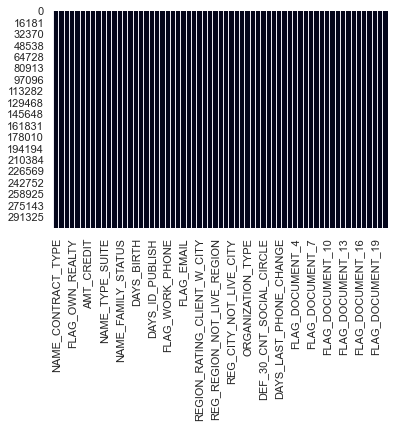

In [9]:
ax = sns.heatmap(df_train.isnull(), cbar=False)

Dividing data according to their columns types: Ordinal (categorical), Nominal (categorical), Numerical
In order to apply appropriate individual pre-process

In [9]:
ordinal_columns = ["NAME_EDUCATION_TYPE"]
nominal_columns = list(df_train.select_dtypes(include="object").drop("NAME_EDUCATION_TYPE", axis=1))
numeric_columns = list(df_train.select_dtypes(include="number"))

# Make sure all columns are selected
assert len(ordinal_columns) + len(nominal_columns) + len(numeric_columns) == len(df_train.columns), "Number of selectionned columns doesn't match with number of all columns"

Pre-process for each columns category
Ordinal: Replace categories with judicious values
Nominal: One hot enconding
Numerical: Minmax



In [10]:
ordinal_mapper = {"Academic degree":1, "Lower secondary":2, "Secondary / secondary special":3, "Incomplete higher":4, "Higher education":5}
df_train["NAME_EDUCATION_TYPE"].replace(ordinal_mapper, inplace=True)
numeric_columns.append(ordinal_columns[0])

df_categorical_encoded = pd.get_dummies(data=df_train[nominal_columns])

df_numeric_normalized = (df_train[numeric_columns]-df_train[numeric_columns].min())/(df_train[numeric_columns].max()-df_train[numeric_columns].min())

Concatenate categorical & numeric dataframe

In [11]:
df_scaled = pd.concat([df_categorical_encoded, df_numeric_normalized], axis=1)
df_scaled.shape

(306219, 153)

## II - Feature selection

In [12]:
# Number of feature to keep
N_feature = 30

### a. PCA
Using PCA to convert a large number of correlated variables into a smaller dataset of uncorrelated variables.

In [14]:
pca = PCA(n_components=N_feature)
pca_df = pd.DataFrame(pca.fit_transform(df_scaled), columns=['PCA%i' % i for i in range(N_feature)], index=df_scaled.index)
pca_df

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,...,PCA20,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29
0,-0.545308,-0.174814,-0.251261,0.117562,1.179500,-0.132394,-1.044286,0.130329,-0.371065,0.511615,...,-0.540594,0.290199,0.071934,0.213892,-0.093685,0.064335,-0.064099,0.064228,0.101990,-0.152556
1,0.168492,-0.700235,0.705659,-0.129844,-1.090700,0.448138,-0.100297,0.460287,0.573354,0.921598,...,0.194037,0.603880,0.200932,0.663305,0.188110,0.149982,-0.071463,-0.035093,0.088756,0.041381
2,-0.795780,0.917001,-0.304690,0.230008,0.965440,-1.248675,0.211605,0.705961,-0.522264,0.859219,...,-0.058272,-0.474165,-0.084826,-0.089515,-0.097784,-0.115092,-0.142300,0.101521,-0.144139,-0.073380
3,0.022410,-0.920453,-0.541823,0.029541,0.460807,-0.487079,-0.405515,-0.248994,0.088040,-0.127557,...,0.463487,0.167697,0.070504,0.225486,-0.341058,0.102040,-0.099561,0.020903,-0.076092,-0.005883
4,-0.599291,0.210183,-0.199838,0.280077,1.792392,0.308311,0.390836,-0.135178,-0.053466,-0.064971,...,-0.537036,0.418015,-0.318153,0.023867,-0.203192,-0.181539,0.078299,-0.295292,-0.365879,-0.210735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,-0.585854,0.040949,1.242201,0.227913,1.089576,-0.390206,-0.348244,0.686315,0.371998,-0.160985,...,0.551051,0.353596,-0.435095,-0.246240,0.619144,-0.318686,0.228604,-0.511013,0.194605,-0.386413
307507,1.952648,0.029145,-0.059862,-0.059548,0.252753,-0.043042,-0.290987,-0.496257,-0.642646,0.430614,...,0.030634,0.169575,-0.037572,-0.059636,0.186530,0.028494,0.026149,-0.057898,-0.521550,-0.116689
307508,-0.198891,-0.969517,-0.508327,-0.189143,0.688843,0.152333,0.532089,-0.857139,-0.153501,-0.290260,...,0.073249,0.563876,-0.436470,-0.320777,0.684776,-0.145321,0.274105,-0.598321,0.574121,0.683705
307509,-0.008469,-0.607313,-0.480473,0.707794,-0.399728,0.810355,0.227697,-0.280556,-0.089179,-0.609740,...,0.002161,0.042585,0.877688,-0.241169,0.077815,-0.522466,-0.070861,0.047082,-0.021860,-0.142957


### b. SelectKBest from Scikit-Learn with chi2 (classification)


<AxesSubplot:>

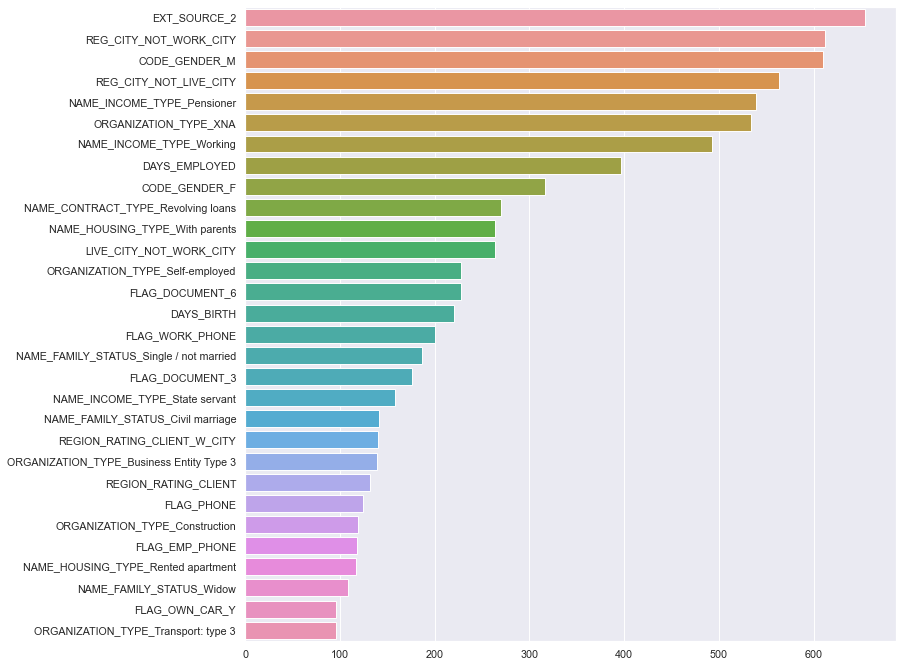

In [13]:
model = SelectKBest(score_func=chi2, k=N_feature)
model.fit(df_scaled, target)

feat_importances_01 = pd.Series(model.scores_, index=df_scaled.columns)
feat_importances_01.sort_values(ascending=False, inplace=True)
feat_importances_01 = feat_importances_01[:N_feature]
x, y = list(feat_importances_01.index), list(feat_importances_01.values)

fig, ax = plt.subplots(figsize=(12,12), dpi=70)
sns.barplot(x=y, y=x, ax=ax, orient="h")

### c. Feature importance with decision tree

<AxesSubplot:>

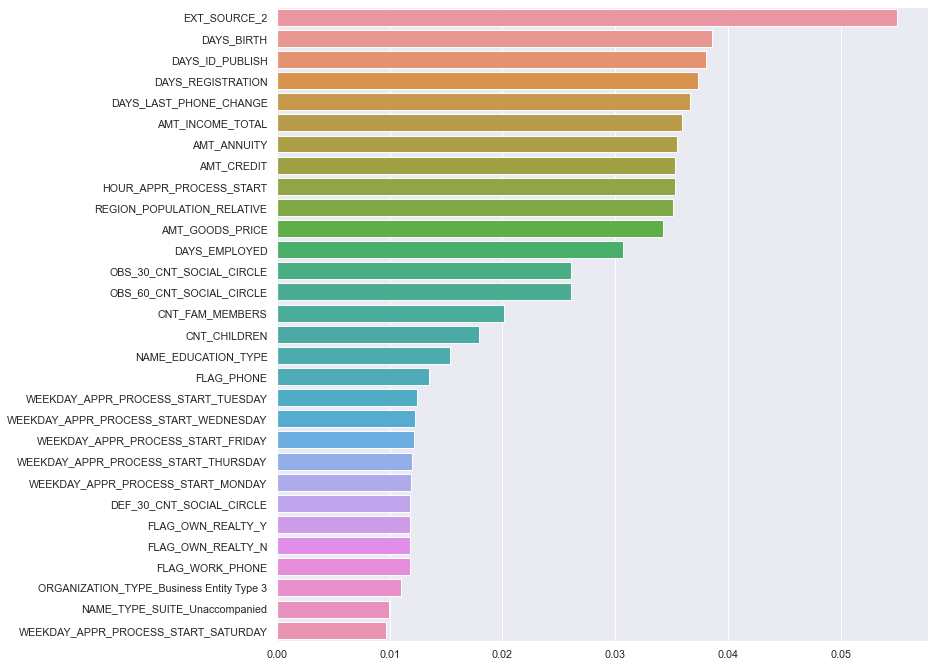

In [14]:
model = ExtraTreesClassifier()
model.fit(df_scaled, target)

feat_importances = pd.Series(model.feature_importances_, index=df_scaled.columns).nlargest(N_feature)
x, y = list(feat_importances.index), list(feat_importances.values)

fig, ax = plt.subplots(figsize=(12,12), dpi=70)
sns.barplot(x=y, y=x, ax=ax, orient="h")

### Select relevant feature of those 2 methods
Take first 30 features of each feature selection method and combine these, also make sur they refer to a real column name and not a one hot encoded value.

In [15]:
selected_features = list(set(list(feat_importances_01[:N_feature].index) + list(feat_importances[:N_feature].index)))

In [16]:
for x in df_train.columns:
        for i,y in enumerate(selected_features):
                if y in x or x in y:
                        selected_features[i] = x
selected_features = list(set(selected_features))

In [17]:
print(*selected_features, sep=" - ")

AMT_INCOME_TOTAL - DAYS_EMPLOYED - AMT_GOODS_PRICE - EXT_SOURCE_2 - AMT_CREDIT - HOUR_APPR_PROCESS_START - OBS_60_CNT_SOCIAL_CIRCLE - REG_CITY_NOT_LIVE_CITY - LIVE_CITY_NOT_WORK_CITY - FLAG_DOCUMENT_6 - NAME_CONTRACT_TYPE - FLAG_DOCUMENT_3 - DAYS_LAST_PHONE_CHANGE - FLAG_PHONE - NAME_EDUCATION_TYPE - FLAG_OWN_REALTY - NAME_FAMILY_STATUS - DAYS_REGISTRATION - NAME_HOUSING_TYPE - ORGANIZATION_TYPE - WEEKDAY_APPR_PROCESS_START - REGION_RATING_CLIENT_W_CITY - CODE_GENDER - CNT_CHILDREN - OBS_30_CNT_SOCIAL_CIRCLE - CNT_FAM_MEMBERS - FLAG_EMP_PHONE - DAYS_ID_PUBLISH - NAME_INCOME_TYPE - DEF_30_CNT_SOCIAL_CIRCLE - REGION_POPULATION_RELATIVE - FLAG_WORK_PHONE - NAME_TYPE_SUITE - REG_CITY_NOT_WORK_CITY - AMT_ANNUITY - FLAG_OWN_CAR - DAYS_BIRTH


## III - Pre-Process (rewind)
Apply pre-processing steps independently on the train and the test set

In [18]:
df = pd.read_csv(train_csv)

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)

In [20]:
train = train[selected_features + ["TARGET", "SK_ID_CURR"]]
test = test[selected_features + ["TARGET", "SK_ID_CURR"]]

In [21]:
train.fillna(train.median(), inplace=True)
train.dropna(inplace=True)

test.fillna(test.median(), inplace=True)
test.dropna(inplace=True)

train.shape, test.shape

((214337, 39), (91882, 39))

In [22]:
id_train, target_train = train["SK_ID_CURR"], train["TARGET"]
id_test, target_test = test["SK_ID_CURR"], test["TARGET"]
train.drop(["TARGET", "SK_ID_CURR"], inplace=True, axis=1)
test.drop(["TARGET", "SK_ID_CURR"], inplace=True, axis=1)
id_train.shape, target_train.shape, id_test.shape, target_test.shape, train.shape, test.shape

((214337,), (214337,), (91882,), (91882,), (214337, 37), (91882, 37))

In [23]:
ordinal_columns = ["NAME_EDUCATION_TYPE"]
nominal_columns = list(train.select_dtypes(include="object").drop("NAME_EDUCATION_TYPE", axis=1))
numeric_columns = list(train.select_dtypes(include="number"))

# Make sure all columns are selected
assert len(ordinal_columns) + len(nominal_columns) + len(numeric_columns) == len(train.columns), "Number of selectionned columns doesn't match with number of all columns"

In [24]:
ordinal_mapper = {"Academic degree":1, "Lower secondary":2, "Secondary / secondary special":3, "Incomplete higher":4, "Higher education":5}
train["NAME_EDUCATION_TYPE"].replace(ordinal_mapper, inplace=True)
test["NAME_EDUCATION_TYPE"].replace(ordinal_mapper, inplace=True)
numeric_columns.append(ordinal_columns[0])

train_categorical_encoded = pd.get_dummies(data=train[nominal_columns])
test_categorical_encoded = pd.get_dummies(data=test[nominal_columns])

train_numeric_normalized = (train[numeric_columns]-train[numeric_columns].min())/(train[numeric_columns].max()-train[numeric_columns].min())
test_numeric_normalized = (test[numeric_columns]-test[numeric_columns].min())/(test[numeric_columns].max()-test[numeric_columns].min())

In [25]:
train_scaled = pd.concat([train_categorical_encoded, train_numeric_normalized], axis=1)
test_scaled = pd.concat([test_categorical_encoded, test_numeric_normalized], axis=1)
train_scaled.shape, test_scaled.shape

((214337, 127), (91882, 127))

## IV - Dealing with Classes imbalance

<AxesSubplot:xlabel='TARGET', ylabel='Count'>

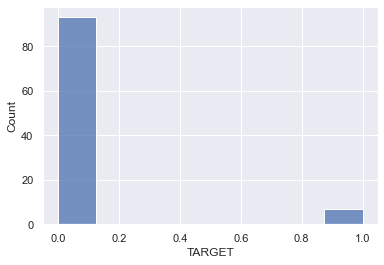

In [27]:
sns.histplot(target_train.head(100))

Save results

In [26]:
import pickle

data = {"train":(train_scaled, target_train), "test":(test_scaled, target_test)}
save_file = os.path.sep.join([wd, "asset", "data", "scaled_data.csv"])

with open(save_file, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)